Here, a system of n spins coupled via sigma^+, sigma^- gates is considered where every m-th spin can be (projectively) measured along an axis of angles theta, phi. The measurement angles and couplings are the control parameters.

In [ ]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

from feedback_grape.utils.operators import (
    sigmax,
    sigmay,
    sigmaz,
    sigmap,
    sigmam,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.fgrape import optimize_pulse, Gate, Decay
import jax
from jax import numpy as jnp
from numpy import flip
from library.utils.qubit_chain_1D import embed
from library.utils.plot_matrix import plot_matrix
from tqdm import tqdm
from jax.scipy.linalg import expm
from math import ceil

# Training parameters
N_timesteps = range(1,6) # Number of time steps to test
N_samples = 5 # Number of random initializations to test
N_training_iterations = 1000 # Number of training iterations
learning_rate = 0.02 # Learning rate

# System parameters
n = 5 # Number of qubits
measurement_sites = [0, 3] # Sites where measurements are performed (0-indexed)
flip_sites = [2, 4] # Sites to be flipped (0-indexed)
control_qubit = 0 # Qubit where control rotations are applied (0-indexed)
decay_constant = jnp.sqrt(0.005) # Decay constant for amplitude damping

# Initial and target state with excitation at flip_sites
psi = basis(2**n, 0)
for k in flip_sites:
    psi = embed(sigmax(), k, n) @ psi
rho_excited = psi @ psi.conj().T
rho_excited /= jnp.trace(rho_excited) # Normalize

# Control operators (bloch rotation on control qubit and sigmam, sigmap between neighboring qubits)
def transport_unitary(params):
    return expm(-1j*sum([
        -t*embed(sigmap(), i, n)@embed(sigmam(), i+1, n) - t*embed(sigmam(), i, n)@embed(sigmap(), i+1, n)
        for i,t in enumerate(params)
    ]))

def initialize_transport_gates(key):
    return Gate(
        gate = transport_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(n-1,), # n-1 couplings
            minval=0.0,
            maxval=1.0,
            dtype=float,
        ),
        measurement_flag=False,
    )

def rotation_unitary(params):
    alpha, beta = params
    return expm(-1j*(alpha*embed(sigmax(), control_qubit, n) + beta*embed(sigmay(), control_qubit, n)))

def initialize_rotation_gate(key):
    return Gate(
        gate = rotation_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(2,), # alpha, beta
            minval=-jnp.pi,
            maxval=jnp.pi,
            dtype=float,
        ),
        measurement_flag=False,
    )

# Measurement operator (projective measurement along axis defined by theta, phi)
def povm(measurement_outcome, params, k):
    theta, phi = params
    x,y,z = jnp.sin(theta)*jnp.cos(phi), jnp.sin(theta)*jnp.sin(phi), jnp.cos(theta)

    S = x*sigmax() + y*sigmay() + z*sigmaz()
    P1 = (jnp.eye(2) + S)/2
    P2 = (jnp.eye(2) - S)/2

    return jnp.where(
        measurement_outcome == 1,
        embed(P1, k, n),
        embed(P2, k, n),
    )

def initialize_povm_gates(key):
    povm_gates = []
    for k in measurement_sites:
        povm_gates.append(
            Gate(
                gate = lambda measurement_outcome, params, k=k: povm(measurement_outcome, params, k) + povm(measurement_outcome, params, k),
                initial_params=jax.random.uniform(
                    jax.random.PRNGKey(key+i),
                    shape=(2,), # theta, phi
                    minval=-jnp.pi,
                    maxval=jnp.pi,
                    dtype=float,
                ),
                measurement_flag=True,
            )
        )

    return povm_gates

# Decay operator (amplitude damping on all qubits)
decay_gate = Decay(c_ops=[decay_constant * embed(sigmap(), k, n) for k in range(n)])

# Assert that measurement operator is valid
assert jnp.allclose(povm(-1, (0, 0), 0) + povm(1, (0, 0), 0), jnp.eye(2**n)), "Measurement operators do not sum to identity"

fidelity_lists  = []
fidelity_labels = []

In [2]:
from library.utils.FgResult_to_dict import FgResult_to_dict
import json

for num_time_steps in N_timesteps: # Number of time steps to test
    print(f"Running for {num_time_steps} time steps")
    best_result = None
    fidelity_list = []
    for i in tqdm(range(N_samples)):
        # Initialize time evolution operators (measurements followed by rotation on control qubit and transport)
        #system_params = initialize_povm_gates(key=i) + [initialize_rotation_gate(key=i), initialize_transport_gates(key=i)]
        system_params = initialize_povm_gates(key=i) + [initialize_rotation_gate(key=i), decay_gate, initialize_transport_gates(key=i), decay_gate]

        # Training
        result = optimize_pulse(
            U_0=rho_excited,
            C_target=rho_excited,
            system_params=system_params,
            num_time_steps=num_time_steps,
            mode="lookup",
            goal="fidelity",
            max_iter=N_training_iterations,
            convergence_threshold=1e-6,
            learning_rate=learning_rate,
            evo_type="density",
            batch_size=8,
            eval_batch_size=10,
        )

        fidelity_list.append(result.final_fidelity)
    
        if best_result is None or result.final_fidelity > best_result.final_fidelity:
            best_result = result
    print(f"Max fidelity for {num_time_steps} time steps: {max(fidelity_list)}")
    fidelity_lists.append(fidelity_list)
    fidelity_labels.append(f"t={num_time_steps} (1)")

    # Save the best result
    with open(f"best_result_lookup_timesteps={num_time_steps}.json", "w") as f:
        json.dump(FgResult_to_dict(best_result), f)

# Play a sound when done
import os
os.system('say "fertig"')

Running for 1 time steps


100%|██████████| 5/5 [05:35<00:00, 67.06s/it]


Max fidelity for 1 time steps: 0.980198560811285


0

max fidelity: t=1 (1) 0.980198560811285


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

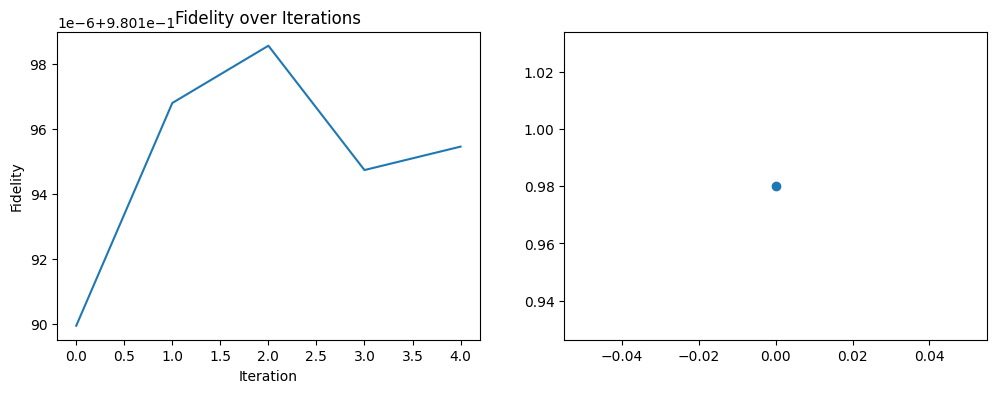

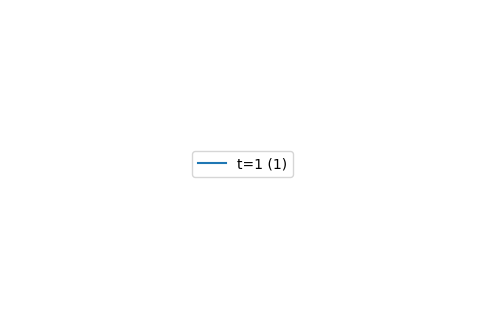

In [3]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for fidelities, label in zip(fidelity_lists, fidelity_labels):
    ax1.plot(fidelities, label=label)
    print(f"max fidelity: {label}", max(fidelities))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fidelity")
ax1.set_title("Fidelity over Iterations")

ax2.plot([max(fidelities) for fidelities in fidelity_lists], label=label, marker="o", linestyle='None')

# legend in seperate figure
fig2, ax2 = plt.subplots(1,1, figsize=(6,4))
ax2.legend(*ax1.get_legend_handles_labels(), loc='center')
ax2.axis('off')

In [4]:
a = [0.25002643878923675, 0.5624969306225057, 0.6816929873851241, 0.7720503758240014, 0.8550823259569829]